<a href="https://colab.research.google.com/github/wanderloop/WanderlustAI/blob/master/X1_to_midpoint.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from numpy import nan, linspace, min, max, reshape, mean, std, int16, float32, array
from pandas import DataFrame, read_csv, concat, set_option
set_option('display.max_columns', None)
set_option('display.max_rows', None)
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
!pip install pandas_profiling==2.8.0
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from plotly.figure_factory import create_table
!pip install shap
from shap import initjs, TreeExplainer, summary_plot, force_plot
from sklearn.linear_model import Lasso
from sklearn.impute import KNNImputer
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import IsolationForest
from scipy.stats import t, jarque_bera
!pip install researchpy
from researchpy import summary_cont
from gc import collect
from flask import Flask, request, render_template
!pip install flask-ngrok
from flask_ngrok import run_with_ngrok
from pickle import dump, load
from os import urandom
from IPython.display import clear_output
clear_output()

In [ ]:
!pip list | grep numpy
!pip list | grep pandas
!pip list | grep pandas_profiling
!pip list | grep matplotlib
!pip list | grep plotly
!pip list | grep shap
!pip list | grep scikit-learn
!pip list | grep scipy
!pip list | grep statsmodels
!pip list | grep researchpy
!pip list | grep Flask
!pip list | grep flask-ngrok
!pip list | grep ipython

numpy                         1.18.5         
pandas                        1.0.5          
pandas-datareader             0.8.1          
pandas-gbq                    0.11.0         
pandas-profiling              2.8.0          
sklearn-pandas                1.8.0          
matplotlib                    3.2.2          
matplotlib-venn               0.11.5         
plotly                        4.4.1          
shap                          0.36.0         
scikit-learn                  0.22.2.post1   
scipy                         1.4.1          
statsmodels                   0.10.2         
researchpy                    0.2.3          
Flask                         1.1.2          
flask-ngrok                   0.0.25         
ipython                       5.5.0          
ipython-genutils              0.2.0          
ipython-sql                   0.3.9          


In [ ]:
%%writefile requirements.txt

numpy==1.18.5
pandas==1.0.5
pandas-profiling==2.8.0
matplotlib==3.2.2
plotly==4.4.1
shap==0.36.0
scikit-learn==0.22.2.post1
scipy==1.4.1
statsmodels==0.10.2
researchpy==0.2.3
Flask==1.1.2
flask-ngrok==0.0.25
ipython==5.5.0
catboost==0.24.1
opencv-python==4.1.2.30
regex==2019.12.20
joblib==0.16.0

Writing requirements.txt


In [ ]:
df = read_csv('https://raw.githubusercontent.com/wanderloop/WanderlustAI/master/assumed_pha_thousand.csv',
              
              dtype={'X1': 'int16',
                     'Y1': 'int16',
                     'X2': 'int16',
                     'Y2': 'int16',
                     'Area': 'int16',
                     'long': 'float32',
                     'lat': 'float32',
                     'Long_minus': 'int16',
                     'Lat_minus': 'int16',},
              
              low_memory=True,
              usecols='X1 X2'.split())

data = create_table(df.head())
data.show()

In [ ]:
# Creating new feature: MPX
df['MPX'] = (df['X1'] + df['X2']) / 2
df = df.drop(['X2'],
             axis=1,)

df['MPX'] = df['MPX'].astype('float32')
data = create_table(df.head())
data.show()

In [ ]:
del data
collect() # Garbage collection

41484

In [ ]:
print(df.columns.values)

['X1' 'MPX']


In [ ]:
tail = create_table(df.tail())
tail.show()

In [ ]:
del tail
collect()

19072

In [ ]:
frames = [df.head(), df.tail()]
conc_data_row = concat(frames,
                       axis=0, # Row-wise operation
                       join='outer',) # Returns both dataframes' columns

conc_data_row = create_table(conc_data_row)
conc_data_row.show()

In [ ]:
del conc_data_row
collect()

22300

In [ ]:
assert df['X1'].notnull().all()
assert df['MPX'].notnull().all()

In [ ]:
print('Duplicated entries:',
      df.duplicated().sum())
df[df.duplicated()].isna().median()

Duplicated entries: 0


X1    NaN
MPX   NaN
dtype: float64

In [ ]:
df.drop_duplicates(keep=False, # Drop all duplicates
                   inplace=True,)
print(df.shape, "Duplicated rows have been removed.")

(18, 2) Duplicated rows have been removed.


In [ ]:
# Dropping columns with more than 50% missing values
df = df.dropna(thresh=df.shape[0]*0.5, 
               how='all', # Only drop columns when all values are NA
               axis='columns',)
df.shape

(18, 2)

In [ ]:
df.info(verbose=True,
        memory_usage='deep',) # Actual memory usage calculation

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18 entries, 0 to 17
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X1      18 non-null     int16  
 1   MPX     18 non-null     float32
dtypes: float32(1), int16(1)
memory usage: 236.0 bytes


In [ ]:
profile = ProfileReport(df,
                        title='X1-Midpoint Report',
                        explorative=True, # Deeper data insights
                        progress_bar=True,)
profile.to_notebook_iframe() # Display report in output console

In [ ]:
del profile
collect()

58650

In [ ]:
# Calculating t-statistic
sample_size = 18
print(t.ppf(1-0.025, sample_size - 1))

2.1098155778331806


In [ ]:
# Checking the distribution of the target variable
DataToTest = df['MPX']
stat, p = jarque_bera(DataToTest)
print(f'stat={stat}', 
      f'p={p}')

if p > 0.05:
    print('Normal distribution')
else:
    print('Not a normal distribution')

stat=1.4596560879827516 p=0.48199186436181884
Normal distribution


In [ ]:
summary = summary_cont(df[['X1',
                           'MPX',]])

summary = create_table(summary)
summary.show()

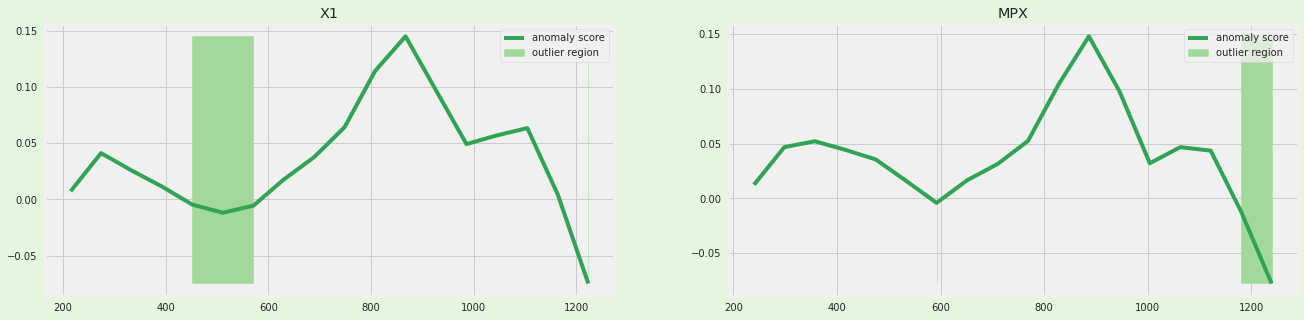

In [ ]:
cols = df
fig, axs = plt.subplots(1,
                        2,
                        figsize=(20, 5),)
fig.set_facecolor('#e5f5e0')
fig.set_edgecolor('k')
axs = axs.reshape(-1) # Return a 1D array

for i, column in enumerate(cols):
    isolation_forest = IsolationForest(contamination=0.1) # Outlier thresh
    isolation_forest.fit(df[column].to_numpy().reshape(-1, 1)) # 2D array

    xx = linspace(df[column].min(), # Starting value of the sequence
                  df[column].max(), # End value of the sequence
                  len(df), # No. of samples to generate
                  endpoint=True,).reshape(-1, 1) # End value = Last sample
    anomaly_score = isolation_forest.decision_function(xx)
    outlier = isolation_forest.predict(xx)
    
    axs[i].plot(xx,
                anomaly_score,
                label='anomaly score',
                color='#31a354',)
    
    axs[i].fill_between(xx.T[0],
                        min(anomaly_score), # Minimum boundary
                        max(anomaly_score), # Maximum boundary
                        where=outlier==-1, # Threshold to fill in a curve
                        color='#a1d99b', # Fill color
                        alpha=1, # Opacity
                        label='outlier region',)
    
    axs[i].legend(frameon=True) # Show box enclosing the legend text
    axs[i].set_title(column,
                     loc="center",)

In [ ]:
any(df.X1 <= 0)

False

In [ ]:
any(df.MPX <= 0)

False

In [ ]:
# Define predictor (X) and target variables (y)
X = df[['X1']]
y = df['MPX'].to_numpy().reshape(-1, 1)

The predictor variable defined above (X1) was determined through SHAP, Recursive Feature Elimination (RFE), feature importance, and Variance Inflation Factor (VIF). The following code is not a direct part of this notebook. The reason I've not included this code as a direct part of the notebook is due to the fact that RFE requires all features (columns) to be included which I'm not a fond of since after the RFE process, I'll have to update related variables.



```
from numpy import int16, float32
from pandas import DataFrame, read_csv
from plotly.figure_factory import create_table
from sklearn.linear_model import Lasso
!pip install shap
from shap import initjs, TreeExplainer, summary_plot, force_plot
from sklearn.feature_selection import RFE
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Show data
df = read_csv('https://raw.githubusercontent.com/wanderloop/WanderlustAI/master/assumed_pha_thousand.csv',
              
              dtype={'X1': 'int16',
                     'Y1': 'int16',
                     'X2': 'int16',
                     'Y2': 'int16',
                     'Area': 'int16',
                     'long': 'float32',
                     'lat': 'float32',
                     'Long_minus': 'int16',
                     'Lat_minus': 'int16',},
              
              low_memory=True,)

# Create new features
df['MPX'] = (df['X1'] + df['X2']) / 2
df['MPX'] = df['MPX'].astype('float32')
df['MPY'] = (df['Y1'] + df['Y2']) / 2
df['MPY'] = df['MPY'].astype('float32')

data = create_table(df.head())
data.show()

# Define predictor (X) and target variables (y)
X = df[['X1', 'Y1', 'X2', 'Y2', 'MPY',
        'Area', 'long', 'lat', 'Long_minus', 'Lat_minus',]]

y = df['MPX'].to_numpy().reshape(-1, 1)

# Define the model
regr = Lasso(alpha=0.7640, 
             max_iter=50_000,)

# SHAP
X_sampled = X.sample(10,
                     random_state=10,)

explainer = TreeExplainer(regr)
shap_values = explainer.shap_values(X_sampled)

initjs()
force_plot(explainer.expected_value,
           shap_values[0,:],
           X_sampled.iloc[0,:],)
________________________________________________________________________________

initjs()
force_plot(explainer.expected_value,
           shap_values,
           X,)
________________________________________________________________________________

summary_plot(shap_values,
             X_sampled,)
________________________________________________________________________________

summary_plot(shap_values, 
             X_sampled, 
             plot_type="bar",)
________________________________________________________________________________

# Performing RFE
rfe = RFE(regr, 3)
fit = rfe.fit(X, y,)
print("Num features: {}".format(fit.n_features_))
print("Selected features: {}".format(fit.support_))
print("Feature ranking: {}".format(fit.ranking_))
________________________________________________________________________________
Output: Num features: 3
        Selected features: [ True  True False False False False False False False  True]
        Feature ranking: [1 1 4 6 3 5 7 2 8 1]
________________________________________________________________________________
# Calculate feature importance
regr.fit(X, y,)
print(regr.feature_importances_)
________________________________________________________________________________
Output: [27.04260174 36.40487156  2.04547475  4.41668907  3.42191053  5.44478804
         1.57089372 10.18206005  1.08344147  8.38726907]
________________________________________________________________________________
# Train and test parameters
X = df[['X1',
        'X2']]

y = df['MPX'].to_numpy().reshape(-1, 1)

def calc_vif(X):

    # Calculating VIF
    vif = DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

calc_vif(X)
```


In [ ]:
imp = KNNImputer(missing_values=nan, # Missing values marked as nan
                 n_neighbors=5, # No. of nearby values
                 weights='distance', # Nearest value = Greatest influence
                 metric='nan_euclidean',)

In [ ]:
regr = Lasso(alpha=0.7640, 
             max_iter=50_000,)

In [ ]:
pipeline = make_pipeline(imp, regr)
pipeline.fit(X, y.reshape(-1),)

Pipeline(memory=None,
         steps=[('knnimputer',
                 KNNImputer(add_indicator=False, copy=True,
                            metric='nan_euclidean', missing_values=nan,
                            n_neighbors=5, weights='distance')),
                ('lasso',
                 Lasso(alpha=0.764, copy_X=True, fit_intercept=True,
                       max_iter=50000, normalize=False, positive=False,
                       precompute=False, random_state=None, selection='cyclic',
                       tol=0.0001, warm_start=False))],
         verbose=False)

In [ ]:
file = open('regr.pkl', 'wb')
dump(regr, file)

In [ ]:
scores = cross_val_score(pipeline,
                         X, y.reshape(-1),
                         cv=18, # 18-fold split
                         scoring='neg_root_mean_squared_error',
                         n_jobs=-1,) # Use every CPU core
print(scores)

[ -0.35039749  -0.50284663  -8.98570383  -2.1881147   -7.67178494
  -5.54425274  -1.40547199  -4.62673613  -7.96118686 -10.2296435
  -9.01629678  -5.58733805  -2.16106718  -1.25206285  -1.13195823
  -0.06260094 -14.55932932 -14.92754745]


In [ ]:
mean_scores, std_scores = (-1 * scores.mean(), scores.std())
print(f'RMSE: {mean_scores}',
      f'SD: {std_scores}')

RMSE: 5.453574423811558 SD: 4.633236225048701


In [ ]:
%mkdir templates -p

In [ ]:
%%writefile templates/index.html

<!doctype html>
<html lang="en" style="width: 100%; height: 100%; overflow: hidden;">

 <head>

   <meta charset="utf-8">
   <title>MPX Predictor</title>
   <meta http-equiv="X-UA-Compatible" content="IE=edge">
   <meta name="description" content="A Scikit-Learn-based ML model that predicts the midpoint of X">

   <!-- Render correctly on mobile devices -->
   <meta name="viewport" content="width=device-width, initial-scale=1.0, minimum-scale=1.0, shrink-to-fit=no">

   <!-- Add to homescreen for Chrome on Android -->
   <meta name="mobile-web-app-capable" content="yes">
   <meta name="application-name" content="MPX Predictor">
   <meta name="theme-color" content="#303F9F">

   <!-- Add to homescreen for Safari on iOS -->
   <meta name="apple-mobile-web-app-capable" content="yes">
   <meta name="apple-mobile-web-app-status-bar-style" content="black">
   <meta name="apple-mobile-web-app-title" content="MPX Predictor">
   <meta name="apple-mobile-web-app-status-bar-style" content="#303F9F">

   <!-- Tile icon for Win8 -->
   <meta name="msapplication-TileColor" content="#3372DF">
   <meta name="msapplication-navbutton-color" content="#303F9F">
   <script async src="https://www.googletagmanager.com/gtag/js?id=UA-135532366-1"></script>
   <script>function gtag(){dataLayer.push(arguments)}window.dataLayer=window.dataLayer||[], gtag("js",new Date), gtag("config", "UA-135532366-1");</script>

   <!-- Web Application Manifest -->
   <link rel="manifest" href='data:application/manifest+json, { "name": "MPX Predictor", "short_name": "MPX Predictor", "display": "standalone" }' media="screen /> 

   <!-- Bootstrap CSS and JS -->
   <link rel="stylesheet" href="https://stackpath.bootstrapcdn.com/bootstrap/4.5.2/css/bootstrap.min.css" integrity="sha384-JcKb8q3iqJ61gNV9KGb8thSsNjpSL0n8PARn9HuZOnIxN0hoP+VmmDGMN5t9UJ0Z" crossorigin="anonymous" media="screen">
   <link rel="stylesheet" type="text/css" href="https://code.getmdl.io/1.1.3/material.orange-indigo.min.css" media="screen">
   <script defer src="https://code.getmdl.io/1.1.3/material.min.js"></script>

 </head>

   <body>
  
    <!-- Fixed header -->
    <div style="margin: 40px;" class="demo-layout mdl-layout mdl-js-layout mdl-layout--fixed-header">
      <header class="mdl-layout__header mdl-color-text--white mdl-color--indigo-700">

        <!-- Grid -->
        <div class="mdl-cell mdl-cell--12-col mdl-cell--12-col-tablet mdl-grid">
          <div class="mdl-layout__header-row mdl-cell mdl-cell--12-col mdl-cell--12-col-tablet mdl-cell--12-col-desktop"">
            <h3> MPX Predictor </h3>
          </div>
        </div>
      </header>

      <h4> Predict the Midpoint of X </h4>
      <h5> Enter the following value(s) to predict the Midpoint of X </h5>

     <!-- Numeric textfield with floating label -->
      <form action="{{ url_for('predict')}}" method="post">
        <div class="mdl-textfield mdl-js-textfield mdl-textfield--floating-label">
           <input class="mdl-textfield__input" type="text" style="height: 25px;" name="X1" id="vx1" required="required" pattern="-?[0-9]*(\.[0-9]+)?">
           <label class="mdl-textfield__label" for="vx1">Value of X1</label>
           <small class="form-text text-muted">Enter numbers only</small>
        </div>

          <!-- Accent-colored raised button with ripple -->
          <button type="submit" style="margin: 15px;" class="mdl-button mdl-js-button mdl-button--raised mdl-js-ripple-effect mdl-button--accent">Predict</button>
      </form>

      {{ prediction_text }} 

    </div>
   </body>

</html>

Writing templates/index.html


In [ ]:
secret = urandom(24).hex()

# Initialize the server
app = Flask(__name__)
app.logger.info("Starting...")
app.config['SECRET_KEY'] = secret
app.logger.critical(f"secret: {secret}")

# Load the ML model
file = open('regr.pkl', 'rb')
model = load(file)

# Run web-app on a VM
run_with_ngrok(app) 
@app.route("/")
def home(): 
    return render_template('index.html')

# To use the predict button in our web-app
@app.route('/predict', methods=['POST'])
def predict():
    # For rendering results on HTML GUI
    int_features = [float(x) for x in request.form.values()]
    final_features = [array(int_features)]
    prediction = model.predict(final_features)
    output = round(prediction[0], 2) 
    return render_template('index.html', prediction_text=f'The Midpoint of X could be: {output}')
  
app.run()

[2020-09-28 19:48:36,051] CRITICAL in <ipython-input-78-b282fe203d3a>: secret: 8cb7dfd1a3c0623ba6e39abc862eeb5ddbb492d98a91ba33


 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


 * Running on http://ee3a0649b8fc.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


127.0.0.1 - - [28/Sep/2020 19:48:40] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [28/Sep/2020 19:48:41] "GET /favicon.ico HTTP/1.1" 404 -
